In [ ]:
import json
import string
import tensorflow as tf
import re
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = [json.loads(line) for line in open('/content/drive/MyDrive/train.jsonl', 'r')]
val_data=[json.loads(line) for line in open('/content/drive/MyDrive/dev_seen.jsonl', 'r')]
test_data=[json.loads(line) for line in open('/content/drive/MyDrive/test_seen.jsonl','r')]

In [ ]:
train_data

[{'id': '42953',
  'img': 'img/42953.png',
  'label': 0,
  'text': 'its their character not their color that matters'},
 {'id': '23058',
  'img': 'img/23058.png',
  'label': 0,
  'text': "don't be afraid to love again everyone is not like your ex"},
 {'id': '13894',
  'img': 'img/13894.png',
  'label': 0,
  'text': 'putting bows on your pet'},
 {'id': '37408',
  'img': 'img/37408.png',
  'label': 0,
  'text': 'i love everything and everybody! except for squirrels i hate squirrels'},
 {'id': '82403',
  'img': 'img/82403.png',
  'label': 0,
  'text': 'everybody loves chocolate chip cookies, even hitler'},
 {'id': '16952',
  'img': 'img/16952.png',
  'label': 0,
  'text': 'go sports! do the thing! win the points!'},
 {'id': '76932',
  'img': 'img/76932.png',
  'label': 0,
  'text': "fine you're right. now can we fucking drop it?"},
 {'id': '70914',
  'img': 'img/70914.png',
  'label': 1,
  'text': 'tattoos are bad for your health i know 5 million people that had tattoos and they all died'

In [ ]:
val_data

[{'id': '08291',
  'img': 'img/08291.png',
  'label': 1,
  'text': 'white people is this a shooting range'},
 {'id': '46971',
  'img': 'img/46971.png',
  'label': 1,
  'text': 'bravery at its finest'},
 {'id': '03745',
  'img': 'img/03745.png',
  'label': 1,
  'text': 'your order comes to $37.50 and your white privilege discount brings the total to $37.50'},
 {'id': '83745',
  'img': 'img/83745.png',
  'label': 1,
  'text': 'it is time.. to send these parasites back to the desert'},
 {'id': '80243',
  'img': 'img/80243.png',
  'label': 1,
  'text': 'mississippi wind chime'},
 {'id': '05279',
  'img': 'img/05279.png',
  'label': 1,
  'text': "knowing white people , that's probably the baby father"},
 {'id': '01796',
  'img': 'img/01796.png',
  'label': 1,
  'text': 'life hack #23 how to get stoned with no weed'},
 {'id': '53046',
  'img': 'img/53046.png',
  'label': 1,
  'text': "you've heard of elf on a shelf, now get ready for"},
 {'id': '82301',
  'img': 'img/82301.png',
  'label': 1

In [ ]:
print(len(train_data))
print(len(val_data))

8500
500


PRE-PROCESSING

CLEANING THE TEXT

In [ ]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove hashtags
    text = re.sub(r'#\S+', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    #text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    return words

In [ ]:
def create_vocab(data):
    vocab = set()
    for d in data:
        words = preprocess_text(d['text'])
        print(words)
        vocab.update(words)
    word2index = {w: i for i, w in enumerate(vocab)}
    return word2index

In [ ]:
word2index = create_vocab(train_data)


Streaming output truncated to the last 5000 lines.
['we', 'protect', 'pedophiles', 'from', 'being', 'prosecuted']
['muslim', 'strip', 'club']
['adding', 'coolant', 'when', 'the', 'farm', 'equipment', 'overheats']
['when', 'she', 'finally', 'has', 'your', 'own', 'month']
['what', 'we', 'are', 'doing', 'to', 'lgbtq', 'is', 'not', 'right', 'we', 'should', 'give', 'them', 'love']
['only', 'black', 'character', 'in', 'the', 'game', 'passive', 'abiity', 'runs', 'faster', 'under', 'fire']
['the', 'war', 'on', 'drugs', 'is', 'ridiculous', 'thats', 'just', 'more', 'money', 'we', 'could', 'be', 'using', 'to', 'bomb', 'the', 'fuck', 'out', 'of', 'those', 'muslims']
['if', 'you', 'hear', 'people', 'from', 'my', 'past', 'speak', 'of', 'me', 'keep', 'in', 'mind', 'they', 'are', 'speaking', 'of', 'a', 'person', 'they', 'dont', 'even', 'know', 'anymore']
['stupid', 'people', 'she', 'was', 'elected', 'to', 'help', 'not', 'to', 'demise']
['jewish', 'men', 'supporting', 'a', 'politician', 'on', 'views', 

TOKENIZE

In [ ]:
def tokenizer_text(text, word2index, max_seq_length):
    words = preprocess_text(text)
    sequence = [word2index[w] for w in words if w in word2index]
    sequence = pad_sequences([sequence], maxlen=max_seq_length, padding='post', truncating='post')
    return np.squeeze(sequence)


In [ ]:
max_seq_length = 20

train_sequences = np.array([tokenizer_text(d['text'], word2index, max_seq_length) for d in train_data])
val_sequences = np.array([tokenizer_text(d['text'], word2index, max_seq_length) for d in val_data])
test_sequences = np.array([tokenizer_text(d['text'], word2index, max_seq_length) for d in test_data])

In [ ]:
print(train_sequences)

[[7522 2644 1868 ...    0    0    0]
 [1918 6231 4861 ...    0    0    0]
 [8664 4288 3765 ...    0    0    0]
 ...
 [1985 3765 4884 ... 7029 1545 6676]
 [1310 4144 6998 ... 4144 2537  932]
 [3387 3228 2566 ...    0    0    0]]


In [ ]:
train_labels = np.array([d['label'] for d in train_data])
val_labels = np.array([d['label'] for d in val_data])
test_labels = np.array([d['label'] for d in test_data])


LSTM MODEL

In [ ]:
vocab_size = len(word2index)
embedding_dim = 32
hidden_dim = 64

model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_seq_length),
    LSTM(hidden_dim, return_sequences=True),
    LSTM(hidden_dim),
    Dense(1, activation='sigmoid')
])


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=15, batch_size=32)

Epoch 1/15
266/266 [==============================] - 18s 48ms/step - loss: 0.6104 - accuracy: 0.6848 - val_loss: 0.7287 - val_accuracy: 0.5600
Epoch 2/15
266/266 [==============================] - 12s 44ms/step - loss: 0.4887 - accuracy: 0.7740 - val_loss: 0.8069 - val_accuracy: 0.5660
Epoch 3/15
266/266 [==============================] - 12s 44ms/step - loss: 0.4016 - accuracy: 0.8088 - val_loss: 0.8380 - val_accuracy: 0.5700
Epoch 4/15
266/266 [==============================] - 10s 36ms/step - loss: 0.3509 - accuracy: 0.8286 - val_loss: 1.0586 - val_accuracy: 0.5580
Epoch 5/15
266/266 [==============================] - 13s 51ms/step - loss: 0.3174 - accuracy: 0.8408 - val_loss: 1.3136 - val_accuracy: 0.5480
Epoch 6/15
266/266 [==============================] - 12s 44ms/step - loss: 0.2875 - accuracy: 0.8495 - val_loss: 1.7950 - val_accuracy: 0.5400
Epoch 7/15
266/266 [==============================] - 12s 44ms/step - loss: 0.2643 - accuracy: 0.8545 - val_loss: 1.8241 - val_accuracy:

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
tf.keras.models.save_model(model, '/content/sample_data/my_Models')

In [ ]:
!cp -av "/content/sample_data/my_Models" "/content/drive/MyDrive/A4_model"

'/content/sample_data/my_Models' -> '/content/drive/MyDrive/A4_model/my_Models'
'/content/sample_data/my_Models/variables' -> '/content/drive/MyDrive/A4_model/my_Models/variables'
'/content/sample_data/my_Models/variables/variables.data-00000-of-00001' -> '/content/drive/MyDrive/A4_model/my_Models/variables/variables.data-00000-of-00001'
'/content/sample_data/my_Models/variables/variables.index' -> '/content/drive/MyDrive/A4_model/my_Models/variables/variables.index'
'/content/sample_data/my_Models/assets' -> '/content/drive/MyDrive/A4_model/my_Models/assets'
'/content/sample_data/my_Models/fingerprint.pb' -> '/content/drive/MyDrive/A4_model/my_Models/fingerprint.pb'
'/content/sample_data/my_Models/saved_model.pb' -> '/content/drive/MyDrive/A4_model/my_Models/saved_model.pb'
'/content/sample_data/my_Models/keras_metadata.pb' -> '/content/drive/MyDrive/A4_model/my_Models/keras_metadata.pb'


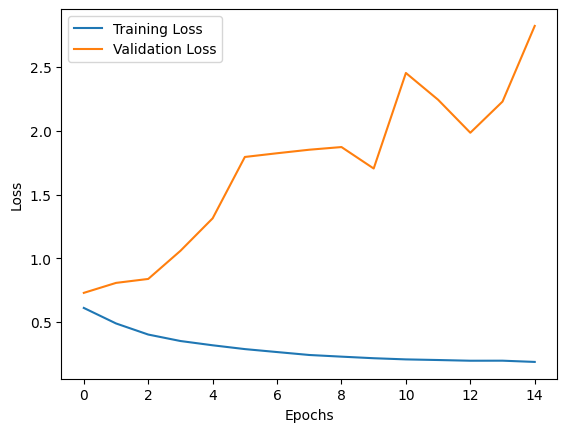

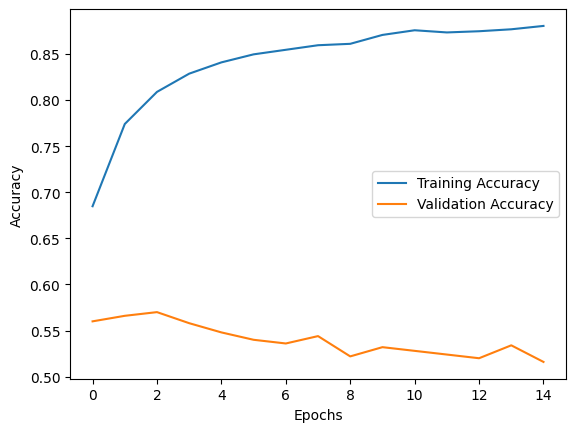

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
y_pred = model.predict(test_sequences)
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(test_labels, y_pred))

32/32 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.54      0.84      0.66       510
           1       0.61      0.26      0.37       490

    accuracy                           0.56      1000
   macro avg       0.58      0.55      0.51      1000
weighted avg       0.58      0.56      0.52      1000



In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, y_pred)
accuracy = accuracy_score(test_labels, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f'Class 0 precision: {precision[0]:.2f}')
print(f'Class 0 recall: {recall[0]:.2f}')
print(f'Class 0 F1 score: {f1_score[0]:.2f}')
print(f'Class 1 precision: {precision[1]:.2f}')
print(f'Class 1 recall: {recall[1]:.2f}')
print(f'Class 1 F1 score: {f1_score[1]:.2f}')


Accuracy: 0.557
Class 0 precision: 0.54
Class 0 recall: 0.84
Class 0 F1 score: 0.66
Class 1 precision: 0.61
Class 1 recall: 0.26
Class 1 F1 score: 0.37


LAST LAYER PREDICTION FOR T-SNE

In [ ]:
import pandas as pd

In [ ]:
non_hateful = pd.read_csv('tsne_test_class0.csv')
hateful = pd.read_csv('tsne_test_class1.csv')

In [ ]:
non_hateful_text = []
for i in np.array(non_hateful['text']):
    non_hateful_text.append(i)

In [ ]:
hateful_text = []
for i in np.array(hateful['text']):
    hateful_text.append(i)

In [ ]:
hateful_sequences = np.array([tokenizer_text(d, word2index, max_seq_length) for d in hateful_text])
non_hateful_sequences = np.array([tokenizer_text(d, word2index, max_seq_length) for d in non_hateful_text])

In [ ]:
model=load_model('/content/drive/MyDrive/A4_model/my_Models')

In [ ]:
last_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
hateful_features = last_layer_model.predict(hateful_sequences)
non_hateful_features = last_layer_model.predict(non_hateful_sequences)

2/2 [==============================] - 0s 13ms/step


In [ ]:
np.save('LSTM_hateful_features.npy', hateful_features)
np.save('LSTM_hateful_label.npy',hateful['label'])
np.save('LSTM_non_hateful_features.npy', non_hateful_features)
np.save('LSTM_non_hateful_label.npy',non_hateful['label'])

In [ ]:
hateful_features = np.load('LSTM_hateful_features.npy')
hateful_label = np.load('LSTM_hateful_label.npy')
non_hateful_features = np.load('LSTM_non_hateful_features.npy')
non_hateful_label = np.load('LSTM_non_hateful_label.npy')

In [ ]:
# Perform t-SNE dimensionality reduction on the features
tsne = TSNE(n_components=2, random_state=42)
tsne_hateful_features = tsne.fit_transform(hateful_features)
tsne_non_hateful_features = tsne.fit_transform(non_hateful_features)

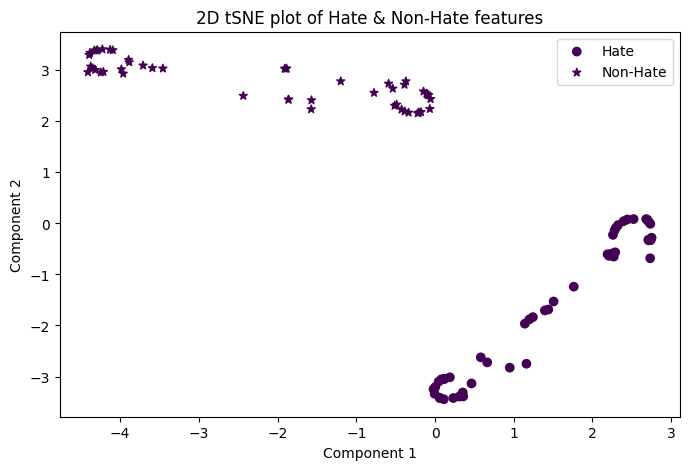

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(tsne_hateful_features[:,0], tsne_hateful_features[:,1], c=hateful_label, marker='o')
plt.scatter(tsne_non_hateful_features[:,0], tsne_non_hateful_features[:,1], c=non_hateful_label, marker='*')

plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.title("2D tSNE plot of Hate & Non-Hate features")
plt.legend(['Hate','Non-Hate'])